# Transient 1D Heat Transfer Tutorial Using DifferentialEquations.jl
# Extended with Non-Linear Dirichtlet Boundary Conditions 

## Import Packages 

In [47]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl
using WriteVTK
using Plots                 # provides contour plot of cell averages 

In [48]:
# import Pkg; Pkg.status() # uncomment to see version of package being used 

## Section 1: Introduction

We extend the heat transfer tutorial of Ferrite with time integration using DifferentialEquations.jl for the following three cases: 

1. Case (1/3): solve 1D heat equation on $\Omega = (0,1)$ with $u(x,t) = \sin(k \, \pi \, x) \, \exp(-k^2 \, \pi^2 \, t)$ with $f(x,t)=0$ and with hom. Dirichlet conditions and initial solution $u(x,0) = \sin(k \, \pi \, x)$;  
2. Case (2/3): solve 1D heat equation on $\Omega = (0,1)$ with time-dependent Dirichlet conditions with Dirichlet boundary condition $u(0) = 2$ and $u(1) = 0$ and source term $f(x,t) = 1 - x$ and initial condition $u(x,0) = 0$; 
3. Case (3/3): solve 1D heat equation on $\Omega = (0,1)$ with non-linear Dirichlet conditions;
   
Solving Case 1/3 and Case 2/3 before Case 3/3 is a structured approach that progressively builds the necessary skills and validates the numerical methods.

**Case 1/3 (Basic Linear Problem):**
This initial step focuses on validating the core FEM spatial discretization and the basic time integration framework (DifferentialEquations.jl). By using a simple linear problem with known analytical solutions, it allows for a direct comparison, ensuring the foundational `K` and `M` matrix assembly and the solver's basic function are correct before adding further complexities.

**Case 2/3 (Time-Dependent Boundary Conditions & Source Term):**
This case introduces crucial elements: time-dependent Dirichlet boundary conditions and a source term. It teaches how to correctly handle inputs that change over time, and how to properly assemble load vectors. Mastering `update!(ch, t)` and the interaction with the ODE solver's right-hand side (`my_rhs!`) and Jacobian (`my_jac!`) becomes essential here. This step prepares the framework for dynamic problems.

**Case 3/3 (Nonlinear Boundary Conditions):**
This is the ultimate goal, building directly on the skills from the previous cases. The non-linearity requires a robust internal Newton-Raphson solver (provided by implicit ODE solvers). However, managing time-dependent inputs (from Case 2/3) and ensuring the correct formulation of the residual and Jacobian (from Case 1/3) are prerequisites for the nonlinear solver to converge reliably. It's a progression from linear to time-dependent linear to time-dependent nonlinear, isolating the challenges at each stage.


<b>How to set non-zero initial guess?</b> Use apply_analytical? 

### Section 1.1: Model Problem 

<b>Motivation</b> The goal of this humble and noble endavor is to solve a heat equation with time-dependent Dirichlet boundary conditions. We therefore consider the model problem for the heat equation $u_t = u_{xx} + f(x,t)$ outlined below. 

<b>Problem Formulation</b> Assume that $0 \leq x \leq 1$ or that $x \in \Omega= [0,1]$ and that $0 \leq t \leq T$. Assume given the non-homogeneous $t$-dependent Dirichlet boundary conditions $u(0,t) = t$ and the homogeneous Dirichlet boundary conditions $u(1,t) = 0$. Assume given the source function $f(x,t) = f(x) = 1-x$. Then the function $u(x,t) = t \, (1-x)$ is the exact solution to the problem. The corresponding initial guess is zero. This model problem is an undressed baby version of the Incompressible Navier Stokes Tutoroial of Ferrite.jl in which the inlet conditions (here the boundary condition in $x=0$) for the velocity is ramped in time.  

<b>Spatial Discretization</b> We employ a classical method of lines approach in which the problem first discretizing the problem in space and subsequently in time. For spatial discretization, we employ a second order central finite difference (element?) scheme on a uniform mesh $\Omega^h$ with $N>1$ intervals, mesh width $h = 1/N$ and nodes $x_i = (i-1) \, h$ for $1 \leq i \leq N+1$. Assume that $K(t)$, $M(t)$ and ${\mathbf f}(t)$ denote the time-dependent $N+1$-by-$N+1$ stiffness matrix (thus including the boundary nodes), the $N+1$-by-$N+1$ mass matrix and $N+1$ load vector, respectively. (Requires elaborating how the boundary conditions are handled inside $K$ and $M$).  

<b>Temporal Discretization</b> Spatial discretization then results in a coupled system of ordinary differential equations 

$$
M \, \frac{d \, {\mathbf u}(t)}{dt} = K \, {\mathbf u}(t) + {\mathbf f}(t) 
\text{ supplied with the initial conditions } {\mathbf u}(0) = {\mathbf 0} \, . 
$$

Should we divide LHS and RHS by $M^{-1}$ and thus obtain an ODE that is more straightforward to treat? 

For temporal discretization, we employ DifferentialEquations.jl by defining the following two (or three?) functions 
1. the right-hand side function $\text{rhs}[{\mathbf u}(t)] = K \, {\mathbf u}(t) + {\mathbf f}(t)$ (plus handling of the boundary conditions?);
2. the Jacobian function $\text{jac}[{\mathbf u}(t)] = K$;
3. functionality for handling the time-dependent Dirichlet boundary conditions( either supplied as a limiter in the time-stepping algorithm, inside the RHS function or otherwise;

<b>Qiuestions</b>
1. examples in other codes?
2. 

## Section 2: Auxiliary Data Structures and Functions 

In [49]:
struct RHSparams
    K::SparseMatrixCSC
    f::Vector 
    ch::ConstraintHandler
    dh::DofHandler
    cvu::CellValues
    fvu::FacetValues
    u::Vector
end

## Section 3: Case (1/3): Mesh Generation, Spatial Discretization and Time Constants 

In [4]:
nels  = (10,)
left  = Vec((0.,))   # start point for geometry: lower-left point of the square 
right = Vec((1.,))   # end point for geometry: upper-right point of the square
grid  = generate_grid(Line, nels, left, right);
xgrid = Vector(0:(1/nels[1]):1.)

ip  = Lagrange{RefLine, 1}()
qr  = QuadratureRule{RefLine}(2)
ipg = Lagrange{RefLine,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefLine}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);
f = zeros(ndofs(dh));

Δt = 0.02
T = 2
t_rise = 100
ch = ConstraintHandler(dh);

∂Ω₁ = getfacetset(grid, "left")
dbc1 = Dirichlet(:u, ∂Ω₁, (x, t) -> 2*(t*(t<=1)+(t>1)))
#dbc1 = Dirichlet(:u, ∂Ω₁, (x, t) -> t)
#dbc1 = Dirichlet(:u, ∂Ω₁, (x, t) -> 0) 
add!(ch, dbc1);

∂Ω₂ = getfacetset(grid, "right")
dbc2 = Dirichlet(:u, ∂Ω₂, (x, t) -> 0)
add!(ch, dbc2)
close!(ch)

update!(ch, 0.0);

In [21]:
# define spatially varying source functin 
function my_source(x)
    return 1-x[1]
end 

function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

        n_basefuncs = getnbasefunctions(cellvalues)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)

        assembler = start_assemble(K, f)

        for cell in CellIterator(dh)

            fill!(Ke, 0)
            fill!(fe, 0)

            cell_coords = getcoordinates(cell)
            Ferrite.reinit!(cellvalues, cell)

            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    coords_qp = spatial_coordinate(cellvalues, q_point, cell_coords)
                    source_qp = my_source(coords_qp)     
                    v = shape_value(cellvalues, q_point, i)
                    ∇v = shape_gradient(cellvalues, q_point, i)
                    fe[i] += source_qp * v * dΩ # 0.1 * v * dΩ
                    for j in 1:n_basefuncs
                        ∇u = shape_gradient(cellvalues, q_point, j)
                        Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                    end
                end
            end

            assemble!(assembler, celldofs(cell), Ke, fe)
        end
        return K, f
end

function assemble_M!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
        Me = zeros(n_basefuncs, n_basefuncs)
        assembler = start_assemble(M)

        for cell in CellIterator(dh)
            fill!(Me, 0)
            Ferrite.reinit!(cellvalues, cell)
            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    for j in 1:n_basefuncs
                        u = shape_value(cellvalues, q_point, j)
                        Me[i, j] += (v * u) * dΩ
                    end
                end
            end

        assemble!(assembler, celldofs(cell), Me)
        end
            
        return M
end

assemble_M! (generic function with 1 method)

### Section 1.3: Intermediate testing 

In [6]:
#@code_warntype assemble_K!(K, f, cvu, dh)

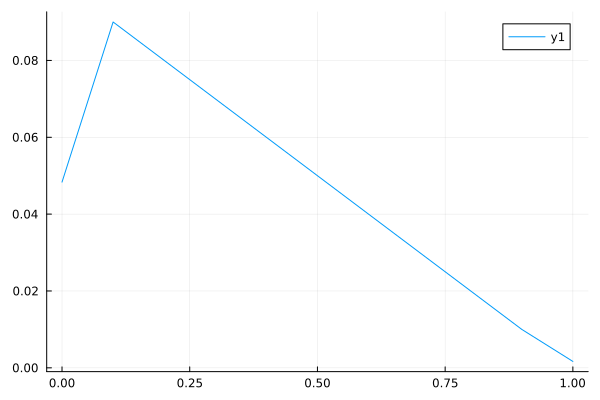

In [7]:
# test rhs-vector: should be (h)*f(x) 
K, f = assemble_K!(K, f, cvu, dh)
plot(xgrid,f)

## Section 4: Case (1/3): Static Solution for Various Time-Dependent Initial Conditions
This section should allow us to document how the updating of the boundary conditions works.  

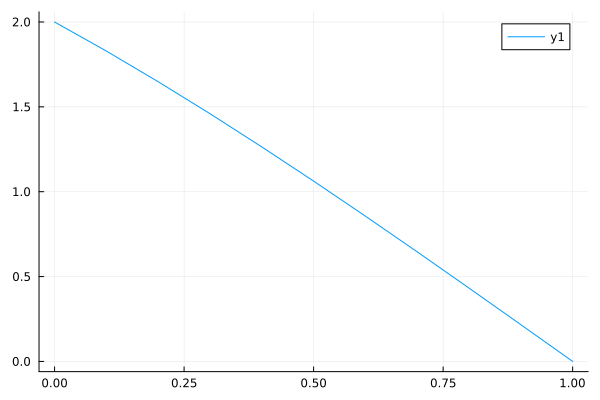

In [8]:
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
A = (Δt .* K) + M;
# We need to save all boundary condition related values of the unaltered system matrix A, which is done by get_rhs_data. 
# The function returns a RHSData struct, which contains all needed information to apply the boundary conditions solely on the 
# right-hand-side vector of the problem.
rhsdata = get_rhs_data(ch, A)

# shows how update works! 
update!(ch, 2)
# display(ch.prescribed_dofs) 
# display(ch.inhomogeneities) 

apply!(K, f, ch)
u = K \ f;

# set numerical solution at the nodes - applies reordering - out is a matrix
#u_computed_at_nodes = reshape_to_nodes(dh, u, :u)

plot(xgrid,u)

## Section 5: Hand-Coded Transient Loop

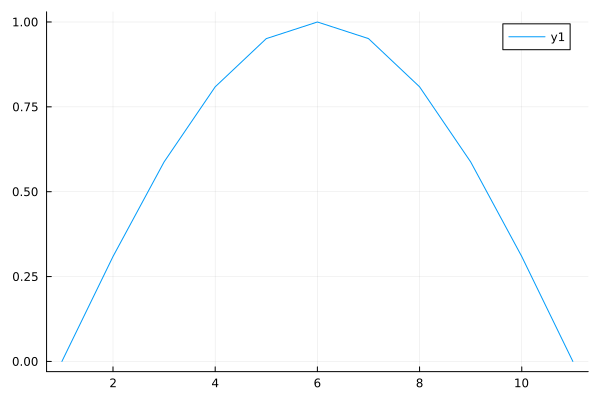

In [9]:
## does plotting of the solution after calling apply_analytical!() work well? Is this independent of the order of the elements? 
un = zeros(ndofs(dh))
apply_analytical!(un, dh, :u, x -> sin(pi*x[1]));
plot(un)

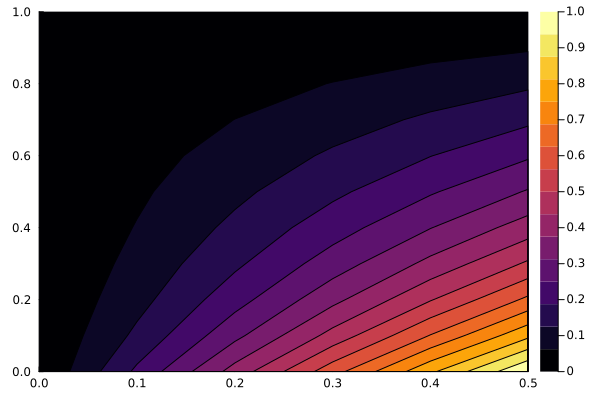

In [10]:
#..assemble stiffness matrix and load vector 
K, f = assemble_K!(K, f, cvu, dh)
#..assemble mass matrix 
M = assemble_M!(M, cvu, dh)
#..assemble time stepping matrix 
A = (Δt .* K) + M;
# We need to save all boundary condition related values of the unaltered system matrix A, which is done by get_rhs_data. 
# The function returns a RHSData struct, which contains all needed information to apply the boundary conditions solely on the 
# right-hand-side vector of the problem.
rhsdata = get_rhs_data(ch, A)
#..modify time-steppig matrix to take boundary conditions into account 
apply!(A, ch);

#..set time step and time interval 
Δt = 0.1
time_interval = 0:Δt:5*Δt 
#..set initial solution 
un            = zeros(ndofs(dh))
# apply_analytical!(un, dh, :u, x -> sin(pi*x[1]));
#..initialize matrix of solution history 
unhist        = zeros(ndofs(dh), length(time_interval))
unhist[:,1]   = un

#..initialize VTK file and write initial solution  
pvd = paraview_collection("transient-heat")
VTKGridFile("transient-heat-0", dh) do vtk
    write_solution(vtk, dh, un)
    pvd[0.0] = vtk
end

for (step, t) in enumerate(time_interval[2:end])
    # display(t)
    #..(1/7): update constraint-handler time-dependent Dirichlet boundary condition
    update!(ch, t)

    #..(2/7): compute time-dependent right-hand-side of the problem
    b = Δt .* f .+ M * un
    
    #..(3/7): apply the boundary conditions of the current time step
    apply_rhs!(rhsdata, b, ch)
    # b[1]=t

    #..(4/7): solve current time step
    u = A \ b

    #..(5/7): update previous solution
    un .= u 

    #..(6/7): store solution   
    unhist[:,step+1] = un

    #..(7/7): store store  
    #VTKGridFile("transient-heat-$step", dh) do vtk
    #    write_solution(vtk, dh, u)
    #    pvd[t] = vtk
    #end
end

contour(Vector(time_interval), xgrid, unhist, fill=true)

This contour plot visually represents the transient temperature distribution, denoted as $u(x, t)$, within a one-dimensional bar. The solution was obtained using the Finite Element Method.

The horizontal axis (X-axis) corresponds to time, $t$, ranging from $0.0$ to $0.5$. This axis illustrates how the temperature profile evolves over a specific duration. The vertical axis (Y-axis) represents the spatial position along the 1D bar, denoted by $x$, extending from $0.0$ to $1.0$. The color bar on the right side of the plot indicates the temperature value, $u$, at any given point $(x, t)$. Darker shades, like black and deep purple, signify lower temperatures, approaching $0$, while brighter colors, particularly yellow, indicate higher temperatures, reaching up to $1.0$.

Physically, at the very beginning of the simulation ($t=0.0$), the entire plot appears uniformly dark. This depicts the initial condition of the problem, where the temperature across the entire bar is set to $u(x, 0) = 0$.

A significant change in color can be observed along the bottom edge of the plot ($x=0.0$). As time progresses, the color transitions from dark to bright yellow. This illustrates a time-dependent Dirichlet boundary condition applied at $x=0.0$, defined as $u(0, t) = 2t$ (for $t \le 1$). This means that as time advances from $0.0$ to $0.5$, the temperature at this end of the bar linearly increases from $0.0$ to $1.0$, which is clearly visible as the yellow region extends to the $1.0$ mark on the color bar by $t=0.5$.

In contrast, along the top edge of the plot ($x=1.0$), the color consistently remains dark. This indicates a fixed Dirichlet boundary condition at $x=1.0$, where the temperature is held constant at $u(1, t) = 0$ throughout the simulation.

The internal contour lines, or isotherms, vividly demonstrate the propagation of heat through the bar over time. Heat, originating from the higher temperature region at $x=0.0$, diffuses towards the lower temperature region at $x=1.0$. As time increases, the warmer areas (represented by yellows and reds) progressively expand further to the right, confirming the diffusion of heat into the bar. The density of these contour lines indicates the steepness of the temperature gradient, showing how rapidly the temperature changes with position.

In [11]:
b = Δt .* f .+ M * un;

In [12]:
apply_rhs!(rhsdata, b, ch);
b;

In [13]:
?apply_rhs!

search: apply_rhs! apply_zero! apply! apply_local! apply_assemble!



```
apply_rhs!(data::RHSData, f::AbstractVector, ch::ConstraintHandler, applyzero::Bool=false)
```

Applies the boundary condition to the right-hand-side vector without modifying the stiffness matrix.

See also: [`get_rhs_data`](@ref).


## Section 6: Case (1/3): Time-Integration Using DifferentialEquations.jl

Remark: Jacobian can be tested using finite differences. 

Q: how does time-step employed depend on value of the diffusion coefficient? 

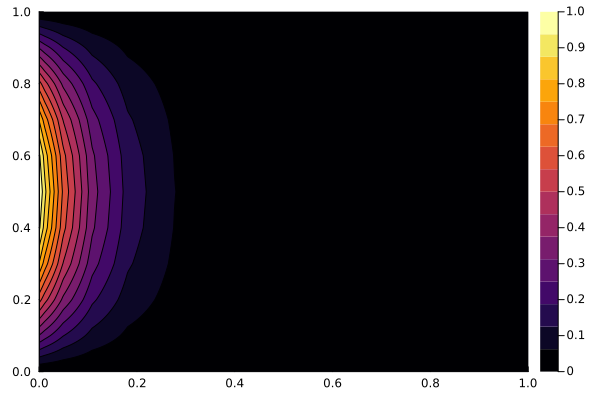

In [19]:
function my_rhs!(du, u, p, t)

    # display(t)

    # u[1] = t
    # Linear contribution (diffusion operator)
    # mul!(du, -K, u) # du .= K * u
    du .= -K * u  

    return
end

function my_jac!(J, u_uc, p::RHSparams, t)

    J .= -K 
    
    return     
end

# set time constants 
T   = 1.

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess
uinit = zeros(ndofs(dh))
apply_analytical!(uinit, dh, :u, x -> sin(pi*x[1]))

# set parameters 
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(my_rhs!, mass_matrix = M; jac = my_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
#sol = solve(problem, Rodas5(autodiff=AutoFiniteDiff(), step_limiter! = ferrite_limiter!), reltol = 1e-3, abstol = 1e-3); 
#sol = solve(problem, Rodas5(autodiff=false, step_limiter! = ferrite_limiter!), reltol = 1e-2, abstol = 1e-2);
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-2, abstol = 1e-2);

# post-processing 
dt = sol.t[2:end] - sol.t[1:end-1]
p1 = bar(sol.t[2:end],dt)

unhist = reduce(hcat,sol.u)
p2 = contour(sol.t,xgrid,unhist, fill=true)

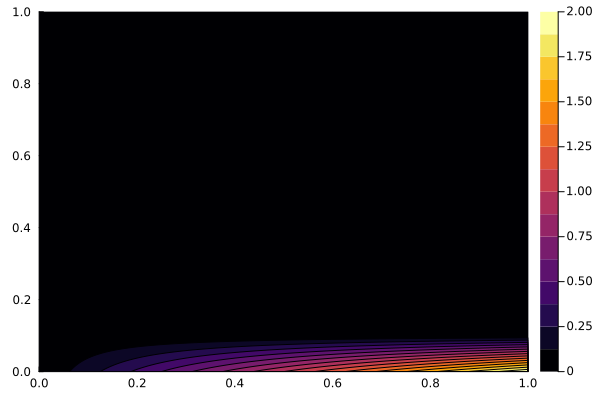

In [15]:
function heat_rhs!(du, u_uc, p::RHSparams, t)

    # display(t)

    @unpack K, f, ch, dh, cvu, fvu, u = p    

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)
    # u[1] = t 

    # Linear contribution (diffusion operator)
    mul!(du, -K, u) # du .= K * u
    du
    # du .= -K * u 

    return
end

function heat_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, f, ch, dh, cvu, fvu, u = p

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  

    return apply!(J, ch)    
end

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

# set time constants 
T   = 1.

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess
uinit = zeros(ndofs(dh))
# apply_analytical!(uinit, dh, :u, x -> sin(pi*x[1]))

# set parameters 
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
#sol = solve(problem, Rodas5(autodiff=AutoFiniteDiff(), step_limiter! = ferrite_limiter!), reltol = 1e-3, abstol = 1e-3); 
sol = solve(problem, Rodas5(autodiff=false, step_limiter! = ferrite_limiter!), reltol = 1e-2, abstol = 1e-2);

# post-processing 
dt = sol.t[2:end] - sol.t[1:end-1]
p1 = bar(sol.t[2:end],dt)

unhist = reduce(hcat,sol.u)
p2 = contour(sol.t,xgrid,unhist, fill=true)

#plot(p1, p2, layout=(1,2))

In [16]:
sol.t;

In [17]:
K*sol.u[end];

In [18]:
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = Δt₀,
    adaptive = true, abstol = 1e5*1.0e-3, reltol = 1e5*1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [100.0]
);

pvd = paraview_collection("transient-heat")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("transient-heat-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end

LoadError: UndefVarError: `Δt₀` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Section 5: Case (2/2): Mesh Generation, Spatial Discretization and Time Constants 
Note that in Case (2/2) the left boundary is not included in the constraint handler. 

In [102]:
nels = (30,20)
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);

f = zeros(ndofs(dh));

ch = ConstraintHandler(dh);

left_patch = getfacetset(dh.grid, "left")
∂Ω₂ = union(getfacetset.((grid,), ["top", "bottom", "right"])...)
dbc2 = Dirichlet(:u, ∂Ω₂, (x, t) -> 0)
add!(ch, dbc2)
close!(ch);

## Section 6: Case (2/2): Time-Integration Using DifferentialEquations.jl

In [103]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

        n_basefuncs = getnbasefunctions(cellvalues)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)

        assembler = start_assemble(K, f)

        for cell in CellIterator(dh)

            fill!(Ke, 0)
            fill!(fe, 0)

            Ferrite.reinit!(cellvalues, cell)

            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    ∇v = shape_gradient(cellvalues, q_point, i)
                    fe[i] += 0. * v * dΩ
                    for j in 1:n_basefuncs
                        ∇u = shape_gradient(cellvalues, q_point, j)
                        Ke[i, j] += 1e-1*(∇v ⋅ ∇u) * dΩ
                    end
                end
            end

            assemble!(assembler, celldofs(cell), Ke, fe)
        end
        return K, f
end

#println(assemble_K!(K, f, cvu, dh))


function assemble_M!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
        Me = zeros(n_basefuncs, n_basefuncs)
        assembler = start_assemble(M)

        for cell in CellIterator(dh)
            fill!(Me, 0)
            Ferrite.reinit!(cellvalues, cell)
            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    for j in 1:n_basefuncs
                        u = shape_value(cellvalues, q_point, j)
                        Me[i, j] += (v * u) * dΩ
                    end
                end
            end

        assemble!(assembler, celldofs(cell), Me)
        end
            
        return M
end

#println(assemble_M!(K, cvu, dh))

assemble_M! (generic function with 1 method)

In [104]:
t_rise = 1                                                #ramping time
res_functional(u,t) = u^2 - 2*(t*(t<=t_rise)+(t>t_rise))  # residu de la cl non linéarie : u^2 - valeur cible
dures_functional(u) = 2*u;                                 # dérivé du résidu 

In [105]:
function heat_rhs_element!(due, ue, fvu, t)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp) # Élément de surface pondéré par la règle de quadrature et le Jacobien

        # 1. Évaluation de la solution approchée 'u' au point de quadrature de la facette
        u_qp = function_value(fvu, qp, ue) # ue est le vecteur des DOFs de l'élément pour u

        # 2. Évaluation du résidu de la condition aux limites non linéaire
        val_qp = res_functional(u_qp, t) # C'est u^2 - Cible(t)

        # 3. Intégration sur la facette (terme dans l'intégrale faible)
        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j) # Valeur de la fonction de base 'j' au point de quadrature
            
            # Ajout de la contribution au vecteur résidu élémentaire (pour les DOFs de cette facette)
            due[j] += val_qp * φⱼ * dΓ # ∫ (u^2 - Cible(t)) * φⱼ dΓ
        end
    end   

    return 
end

heat_rhs_element! (generic function with 1 method)

In [106]:
function heat_jac_element!(Je, ue, fvu)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp) # Élément de surface pondéré

        # 1. Évaluation de la solution approchée 'u' au point de quadrature de la facette
        u_qp = function_value(fvu, qp, ue) # ue est le vecteur des DOFs de l'élément pour u

        # 2. Évaluation de la dérivée du résidu de la CL non linéaire par rapport à u
        duval_qp = dures_functional(u_qp) # C'est 2*u_qp

        # 3. Intégration sur la facette (terme dans l'intégrale Jacobienne)
        for j in 1:n_basefuncs # Boucle sur les fonctions de base (fonctions d'essai φⱼ)
            φⱼ = shape_value(fvu, qp, j) 
            for i in 1:n_basefuncs # Boucle sur les fonctions de base (fonctions test φᵢ)
                φᵢ = shape_value(fvu, qp, i)
                
                # Ajout de la contribution à la matrice Jacobienne élémentaire (Je)
                # Cette intégrale correspond à ∫ (∂R_CL / ∂u) * φᵢ * φⱼ dΓ
                Je[j, i] += duval_qp * φᵢ * φⱼ * dΓ
            end
        end
    end   
    return  # Retourne Je, modifiée en place
end

heat_jac_element! (generic function with 1 method)

In [107]:
function heat_rhs!(du, u_uc, p::RHSparams, t)

    # display(t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution 
    mul!(du, K, u) # du .= K * u

    # Non-Linear contribution 
    range_u = dof_range(dh, :u) 
    n_basefuncs = getnbasefunctions(cvu)
    ue  = zeros(n_basefuncs)
    due = zeros(n_basefuncs)

    for facet in FacetIterator(dh, left_patch)
        Ferrite.reinit!(fvu, facet)
        u_celldofs = @view celldofs(facet)[range_u]
        ue .= @views u[u_celldofs] # u is fetched outside of for-loop 
        fill!(due, 0)
        heat_rhs_element!(due, ue, fvu, t) # first argument is the input output argument 
        assemble!(du, u_celldofs, due) # add to previous values  
    end 
    
    return
end


heat_rhs! (generic function with 1 method)

In [108]:
# test the RHS function 
du   = zeros(ndofs(dh));
u_uc = ones(ndofs(dh));
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(u_uc));

heat_rhs!(du, u_uc, p::RHSparams, 0.)
du;

In [109]:
function heat_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # La Jacobienne de -K*u par rapport à u est simplement -K.
    # On copie les valeurs non-nulles de K dans J.
    nonzeros(J) .= nonzeros(K)  

    assembler = start_assemble(J; fillzero = false)

    n_basefuncs = getnbasefunctions(cvu)
    ue  = zeros(n_basefuncs)
    Je  = zeros(n_basefuncs, n_basefuncs)
    due = zeros(n_basefuncs)
    range_u = dof_range(dh, :u) 

    for facet in FacetIterator(dh, left_patch)
        Ferrite.reinit!(fvu, facet)
        u_celldofs = @view celldofs(facet)[range_u]
        ue .= @views u[u_celldofs] # u is fetched outside of for-loop 
        fill!(Je, 0)
        heat_jac_element!(Je, ue, fvu) # first argument is the input output argument 
        assemble!(assembler, u_celldofs, Je) # add to previous values 
    end    

    return apply!(J, ch)    
end

heat_jac! (generic function with 1 method)

In [110]:
# test the Jacobian function
du   = zeros(ndofs(dh));
u_uc = ones(ndofs(dh));
p    = RHSparams(K, f, ch, dh, cvu, fvu, copy(u_uc));

J = allocate_matrix(dh,ch);
heat_jac!(J, u_uc, p::RHSparams, 0.)
J;

In [111]:
# set time constants 
T   = 2. 

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess 
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3);

┌ Warning: At t=0.04120675354310569, dt was forced below floating point epsilon 6.938893903907228e-18, and step error estimate = 10.551168976777669. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\anouc\.julia\packages\SciMLBase\c6Noy\src\integrator_interface.jl:623


In [112]:
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = 0.01,
    adaptive = true, abstol = 1.0e-3, reltol = 1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [1.0]
);


In [ ]:
# set time constants
T = 2.0

# allocate, assemble and apply bc to mass matrix
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern
jac_sparsity = sparse(K)

# set initial guess
uinit = zeros(ndofs(dh))

# set parameters
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p)
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3);

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = 0.01,
    adaptive = true, abstol = 1.0e-3, reltol = 1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [1.0]
);

# Solution using the initialized integrator (if you prefer this method)
# sol = solve!(integrator)


# Function to post-process nodal solution to cell-averaged values
function mypostprocess(u_nodal_solution::Vector, dh::DofHandler, cvu::CellValues, nels::Tuple{Int, Int})
    numcells = nels[1] * nels[2]
    myu = zeros(numcells) # Will contain cell-averaged values

    for (cell_num, cell) in enumerate(CellIterator(dh))
        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh, :u)
        uloc = u_nodal_solution[celldofs(dh, cell_num)[dof_range_u]] # Nodal solutions for the current cell
        Ferrite.reinit!(cvu, cell) # Reinitialize for quadrature points of the cell

        cell_integral_u = 0.0      # Integral of u over the cell
        cell_physical_area = 0.0   # Physical area of the cell
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point) # Differential volume element
            cell_u_at_qpoint = function_value(cvu, q_point, uloc) # Value of u at the quadrature point
            
            cell_physical_area += dΩ      # Accumulate cell area
            cell_integral_u += cell_u_at_qpoint * dΩ # Accumulate integral of u
        end

        # Calculate the average of u over the cell and assign it
        myu[cell_num] = cell_integral_u / cell_physical_area
    end  

    myu2d = reshape(myu, nels[1], nels[2]) # Reshape the 1D vector into a 2D matrix
    
    return myu2d # Return only the 2D matrix of cell averages
end

# GIF generation part
println("Generating GIF...")
anim = @animate for i in 1:length(sol.t) # Use `sol` directly here
    t_current = sol.t[i]
    u_current = sol.u[i]
    myu2d_at_t = mypostprocess(u_current, dh, cvu, nels) # Ensure mypostprocess is defined
    title_str = "Solution u at t = $(round(t_current, digits=2))"
    p1 = Plots.contour(myu2d_at_t', fill=true, title=title_str, aspect_ratio=:equal, c=:viridis)
    p2 = Plots.surface(myu2d_at_t', title=" ", aspect_ratio=:equal, c=:viridis)
    Plots.plot(p1, p2, layout=(1,2), size=(1000, 500))
end
Plots.gif(anim, "transient_solution_penalty.gif", fps=10)
println("GIF saved to transient_solution_penalty.gif")

try
    # This line attempts to display the GIF directly if the environment supports it
    display("image/gif", read("transient_solution_penalty.gif"))
catch e
    println("Could not display GIF inline. Error: ", e)
    println("Please open 'transient_solution_penalty.gif' manually to view.")
end


### TESTS

Generating GIF...


┌ Warning: At t=0.04120675354310569, dt was forced below floating point epsilon 6.938893903907228e-18, and step error estimate = 10.551168976777669. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\anouc\.julia\packages\SciMLBase\c6Noy\src\integrator_interface.jl:623


GIF saved to transient_solution_penalty.gif


[ Info: Saved animation to C:\Users\anouc\Desktop\HydrogenProject\transient_solution_penalty.gif


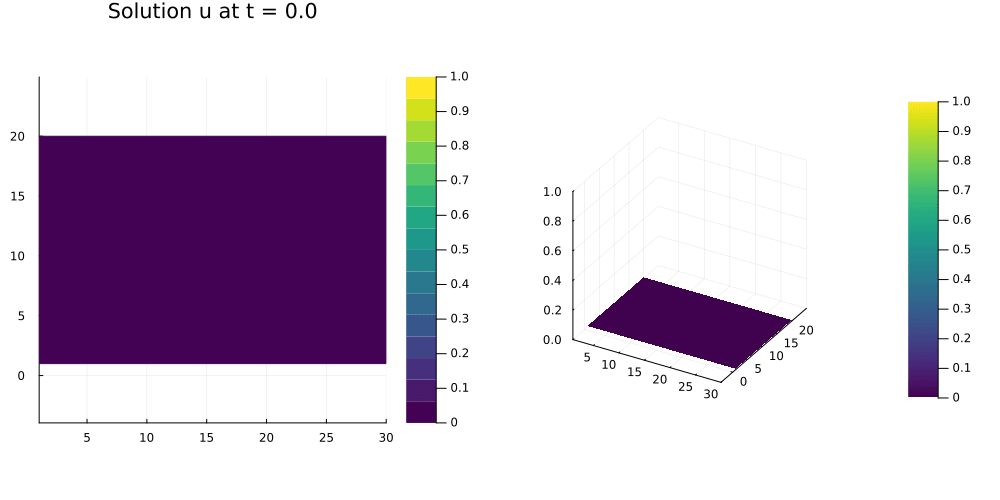

In [100]:
'# set time constants
T = 2.0

# allocate, assemble and apply bc to mass matrix
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern
jac_sparsity = sparse(K)

# set initial guess
uinit = zeros(ndofs(dh))

# set parameters
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p)
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3);

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = 0.01,
    adaptive = true, abstol = 1.0e-3, reltol = 1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [1.0]
);

# Solution using the initialized integrator (if you prefer this method)
# sol = solve!(integrator)


# Function to post-process nodal solution to cell-averaged values
function mypostprocess(u_nodal_solution::Vector, dh::DofHandler, cvu::CellValues, nels::Tuple{Int, Int})
    numcells = nels[1] * nels[2]
    myu = zeros(numcells) # Will contain cell-averaged values

    for (cell_num, cell) in enumerate(CellIterator(dh))
        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh, :u)
        uloc = u_nodal_solution[celldofs(dh, cell_num)[dof_range_u]] # Nodal solutions for the current cell
        Ferrite.reinit!(cvu, cell) # Reinitialize for quadrature points of the cell

        cell_integral_u = 0.0      # Integral of u over the cell
        cell_physical_area = 0.0   # Physical area of the cell
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point) # Differential volume element
            cell_u_at_qpoint = function_value(cvu, q_point, uloc) # Value of u at the quadrature point
            
            cell_physical_area += dΩ      # Accumulate cell area
            cell_integral_u += cell_u_at_qpoint * dΩ # Accumulate integral of u
        end

        # Calculate the average of u over the cell and assign it
        myu[cell_num] = cell_integral_u / cell_physical_area
    end  

    myu2d = reshape(myu, nels[1], nels[2]) # Reshape the 1D vector into a 2D matrix
    
    return myu2d # Return only the 2D matrix of cell averages
end

# GIF generation part
println("Generating GIF...")
anim = @animate for i in 1:length(sol.t) # Use `sol` directly here
    t_current = sol.t[i]
    u_current = sol.u[i]
    myu2d_at_t = mypostprocess(u_current, dh, cvu, nels) # Ensure mypostprocess is defined
    title_str = "Solution u at t = $(round(t_current, digits=2))"
    p1 = Plots.contour(myu2d_at_t', fill=true, title=title_str, aspect_ratio=:equal, c=:viridis)
    p2 = Plots.surface(myu2d_at_t', title=" ", aspect_ratio=:equal, c=:viridis)
    Plots.plot(p1, p2, layout=(1,2), size=(1000, 500))
end
Plots.gif(anim, "transient_solution_penalty.gif", fps=10)
println("GIF saved to transient_solution_penalty.gif")

try
    # This line attempts to display the GIF directly if the environment supports it
    display("image/gif", read("transient_solution_penalty.gif"))
catch e
    println("Could not display GIF inline. Error: ", e)
    println("Please open 'transient_solution_penalty.gif' manually to view.")
end


In [ ]:
'pvd = paraview_collection("transient-heat")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("transient-heat-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end